In [811]:
%%capture --no-stderr
%pip install -U langchain 
%pip install pypdf
%pip install faiss-cpu chroma
%pip install tiktoken
%pip install langgraph
%pip install langchain-google-genai

In [812]:
from langchain.document_loaders import PyPDFLoader
from langchain.schema import Document
from langchain.vectorstores import FAISS
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.prompts import PromptTemplate
from langchain.tools import Tool
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph
from langgraph.prebuilt import ToolNode
from typing_extensions import TypedDict, List
from langchain.chains import LLMChain

In [813]:
import os, getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")

In [814]:
pdfreader = PyPDFLoader('ExamForm.PDF')
text = ""
pages = pdfreader.load_and_split()
for page in pages:
    text += page.page_content

In [815]:
documents = [Document(page_content=text)]
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
docs= text_splitter.split_documents(documents)
print(docs[0].page_content)

Instructions to the Candidate:
1.This Exam form along with fee amount should be submitted to the concerned college .
2.Repeater students should attach attested true copy of the latest mark sheet alongwith this form.
3.This form will be considered 
ONLY AFTER APPROVAL 
from the concern College Login. 
To,
Director, 
Board of Examination & Evaluation, Savitribai Phule Pune University, Pune-
411
 
007
.
Sir/Madam, 
I request permission to present myself at the examination courses, mentioned below .


In [816]:
embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")
vector_db = FAISS.from_documents(docs, embeddings)
retriever = vector_db.as_retriever()
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro")

In [888]:
def expand_query(query: str) -> str:
    return query
def search_vector_db(query: str, k: int = 5) -> List[Document]:
    return vector_db.similarity_search(query, k=k)
def summarize_context(context: str) -> str:
    prompt=PromptTemplate(input_variables=['context'],
                          template="Summarize the following content to provide a concise overview:{context}")
    llm_chain=LLMChain(llm=llm,prompt=prompt)
    summary=llm_chain.run({'context':context})
    # summary=llm()
    return summary
def generate_response(context: str, question: str) -> str:
    prompt=PromptTemplate(input_variables=['context','question'],template="""
    You are a helpful assistant acting as a user guide
    ----------------
    Question:
    {question}
    ----------------
    Context:
    {context}
    ----------------
    Answer:
    """)
    llm_chain=LLMChain(llm=llm,prompt=prompt)
    response=llm_chain.run({'context':context,'question':question})
    return response.strip()

expand_tool = Tool(
    name= "Expand Query",
    func= expand_query,
    description= "Enhance query with additional terms or context"
)
summarize_tool = Tool(
    name= "Summarize Context",
    func= summarize_context,
    description= "Provide summary of the retrieved context"
)
search_tool = Tool(
    name= "Search Vector DB",
    func= search_vector_db,
    description= "Search vector database for relevant documents"
)
generate_tool = Tool(
    name= "Generate Response",
    func= generate_response,
    description= "Generate response based on question and context"
)

In [890]:
class State(TypedDict):
    question: str
    context: List[Document]
    response: str
    expanded_query: str
    summarized_context: str
#node definition
def expand(state: State) -> State:
    state["expanded_query"]= expand_tool.func(state["question"])
    print(f"Expanded Query: {state['expanded_query']}")
    return state

def search(state: State) -> State:
    results= search_tool.func(state["expanded_query"])
    state["context"]= results
    print(f"Retrieved Documents: {[doc.page_content[:100] for doc in results]}")
    return state

def summarize(state: State) -> State:
    context = " ".join(doc.page_content for doc in state["context"]) if state["context"] else ""
    state["summarized_context"]= summarize_tool.func(context)
    print(f"Summarized context: {state['summarized_context']}")
    return state

def generate(state: State) -> State:
    response= generate_tool.func(state["summarized_context"], state["question"])
    state["response"]= response
    print(f"Generated response: {state['response']}")
    return state

workflow = StateGraph(State)
workflow.add_node("Expand", expand)
workflow.add_node("Search", search)
workflow.add_node("Summarize", summarize)
workflow.add_node("Generate", generate)

workflow.set_entry_point("Expand")
workflow.add_edge("Expand", "Search")
workflow.add_edge("Search", "Summarize")
workflow.add_edge("Summarize", "Generate")
workflow.set_finish_point("Generate")

graph=workflow.compile()

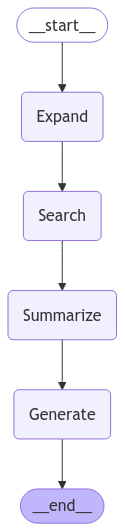

In [892]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [900]:
def run_graph(question: str):
    result= graph.invoke({"question": question})
    return result["response"]

question= "Essential details of candidate"
response= run_graph(question)

Expanded Query: Essential details of candidate
Retrieved Documents: ['Place :_______________ Date : ________________                                                      ', "1.Personal Details:\nName of the Applicant\nTANMAY S GAVASKAR\nName of the Applicant's Mother\nARUNA S G", 'I shall not request for special concession such as change in the time and/or day fixed for the Unive', 'Instructions to the Candidate:\n1.This Exam form along with fee amount should be submitted to the con', 'Project Fee/Dissertation\n0\nEVS Fee\n0\nInternal Marks Fee\n0\nDepartmental Fee\n0\nTranscript Fee\n0\nLate F']
Summarized context: Tanmay S Gavaskar (PRN: 72264234C, Eligibility No: 12022239447) has applied for the T.E.(2019 PAT.)(ELECTRONICS & TELEC.) examination at Savitribai Phule Pune University.  He has declared understanding of the syllabus and responsibility for accurate form completion. The total fee due is 1000.  The form requires principal's signature and college approval before being conside